# Predict Gross Incurred Cost

The data set consists of 71 columns of data from 552-cases. Each case consists of onboarding data of psychosocial screening and the claims cost data. The below Table outlines each of the variables and their relevance. The goal is to predict BO-BS, Y, Z, AA-AC

- BO: Net_total_incurred
- BP: Total_Paid
- BQ: Other_Paid
- BR: Payment_medical
- BS: Other_paid_risk
- Y: Fitness_week2
- Z: Fitness_week6
- AA: Fitness_week12
- AB: Fitness_week26
- AC: Fitness_week52




# Import data

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [140]:
# Import the dataset
df  = pd.read_excel('/content/drive/MyDrive/hackathon/3- Ordered Data for Hackaton.xlsx')

In [141]:
df
df.rename(columns={'Fitness_wekk26': 'Fitness_week26'}, inplace=True)

In [142]:
# Get the data types of each column
column_data_types = df.dtypes

# Display the data types
column_data_types

Gender                                             float64
State                                              float64
Escalated Navigation                                 int64
Intervention Required                              float64
Claim_Segment_Name                                   int64
Date_of_Accident                            datetime64[ns]
Claim_How_Reported_Name                              int64
Claim_Finalised_Date                        datetime64[ns]
Days_Open                                            int64
RTW_Plan_Status_Name                                 int64
Policy_Issue_State_Name                              int64
Accident_type_code                                   int64
Nature_of_loss_code                                  int64
Bodily_location_code                                 int64
Med_Cert_Capacity                                  float64
Med_cert_unfit_restricted_weekdays                 float64
Wage_amount                                        float

In [143]:
# Initialize empty lists to store the names of categorical and numerical columns
categorical_columns = []
numerical_columns = []

# Set a threshold for the number of unique values that a column can have to be considered categorical
# This is just a heuristic and can be adjusted based on the specific dataset and domain knowledge
unique_value_threshold = 20

# Iterate through each column to categorize it as either numerical or categorical
for column, dtype in column_data_types.items():
    if dtype in ['int64', 'float64']:
        num_unique_values = df[column].nunique()
        if num_unique_values <= unique_value_threshold:
            categorical_columns.append(column)
        else:
            numerical_columns.append(column)
    elif dtype == 'object':
        categorical_columns.append(column)
    elif dtype == 'datetime64[ns]':
        # Datetime columns are generally treated separately based on the specific analysis
        # But for now, let's categorize them as categorical
        categorical_columns.append(column)

# Display the categorized columns
categorical_columns, numerical_columns

(['Gender',
  'State',
  'Escalated Navigation',
  'Intervention Required',
  'Claim_Segment_Name',
  'Date_of_Accident',
  'Claim_How_Reported_Name',
  'Claim_Finalised_Date',
  'RTW_Plan_Status_Name',
  'Policy_Issue_State_Name',
  'Accident_type_code',
  'Med_Cert_Capacity',
  'Interstate_workers_flag',
  'Payment_early_intervention_rehab',
  'Fitness_week2',
  'Fitness_week6',
  'Fitness_week12',
  'Fitness_week26',
  'Fitness_week52',
  'Work Status at Referral',
  'Priority',
  'Navigation Status',
  'All calls are recorded, can we continue?',
  'Are You Getting Better?',
  'How Do You Find Your Doctor?',
  'How Do You Find Your Case Manager?',
  'Spoken With Any of Your Co-Workers?',
  'Are you seeing a Therapist?',
  'Is therapy helpful for you?',
  'How long have you had your pain problem?',
  'Rate the pain that you have had?',
  'I can do light work for an hour?',
  'I can sleep at night?',
  'How tense or anxious have you felt?',
  'Have been bothered by feeling depressed?'

In [144]:
# Identify missing values in each column
missing_values_count = df.isnull().sum()

# Filter out columns that have missing values
columns_with_missing_values = missing_values_count[missing_values_count > 0]

# Display columns with missing values and the number of missing values
columns_with_missing_values.sort_values(ascending=False)

Is therapy helpful for you?                 505
Intervention Required                       362
State                                       239
Are you seeing a Therapist?                 199
Claim_Risk_Assessment                        80
How Do You Find Your Case Manager?           69
How Do You Find Your Doctor?                 31
How are you going financially?               13
Felt difficulties were piling up high?       11
You felt that things were going your way     11
Unable to control the important things?      10
Your ability to handle personal problems      9
Fitness_week2                                 7
Fitness_week6                                 7
Fitness_week12                                7
Fitness_week26                                7
Fitness_week52                                7
Other_Paid                                    5
Gender                                        5
Work Status at Referral                       5
First Orebro Score                      

In [145]:
from sklearn.impute import KNNImputer

# Filter numerical columns that have missing values
numerical_columns_with_missing_values = columns_with_missing_values.index.intersection(numerical_columns)

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation on numerical columns
df_numerical_imputed = df[numerical_columns].copy()
df_numerical_imputed[numerical_columns_with_missing_values] = knn_imputer.fit_transform(df[numerical_columns])[
    :, df[numerical_columns].columns.isin(numerical_columns_with_missing_values)
]

# Check if any missing values remain in the numerical columns
df_numerical_imputed[numerical_columns_with_missing_values].isnull().sum()

Med_cert_unfit_restricted_weekdays    0
Payment_medicolegal                   0
Payment_Rehab                         0
Payment_travel_accomodation           0
Payment_weekly_compensation           0
First Orebro Score                    0
Orebro Musculoskeletal Pain Total     0
Initial_estimate                      0
Payment_legal_defendant               0
Payment_investigation_surveillance    0
Total_Paid                            0
Other_Paid                            0
Payment_medical                       0
dtype: int64

In [146]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np

# Filter categorical columns that have missing values
categorical_columns_with_missing_values = columns_with_missing_values.index.intersection(categorical_columns)

# Initialize Multiple Imputer
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)

# Apply Multiple Imputation on categorical columns
# We'll temporarily convert the categorical data to numerical for the imputation process
# Then we'll round the imputed values to the nearest integers to maintain the categorical nature
df_categorical_imputed = df[categorical_columns].apply(pd.to_numeric, errors='coerce').copy()
df_categorical_imputed[categorical_columns_with_missing_values] = np.round(
    iterative_imputer.fit_transform(df_categorical_imputed)
)[:, df_categorical_imputed.columns.isin(categorical_columns_with_missing_values)]

# Check if any missing values remain in the categorical columns
df_categorical_imputed[categorical_columns_with_missing_values].isnull().sum()


Gender                                      0
State                                       0
Intervention Required                       0
Med_Cert_Capacity                           0
Payment_early_intervention_rehab            0
Fitness_week2                               0
Fitness_week6                               0
Fitness_week12                              0
Fitness_week26                              0
Fitness_week52                              0
Work Status at Referral                     0
How Do You Find Your Doctor?                0
How Do You Find Your Case Manager?          0
Are you seeing a Therapist?                 0
Is therapy helpful for you?                 0
Unable to control the important things?     0
Your ability to handle personal problems    0
You felt that things were going your way    0
Felt difficulties were piling up high?      0
How are you going financially?              0
Claim_Risk_Assessment                       0
Payment_legal_plaintiff           

In [147]:
# Combine the imputed numerical and categorical columns to form a fully imputed DataFrame
df_imputed = pd.concat([df_numerical_imputed, df_categorical_imputed], axis=1)

# Reorder the columns to match the original DataFrame
df_imputed = df_imputed[df.columns]

# Check if any missing values remain in the DataFrame
df_imputed.isnull().sum().sum()
# Rename the column 'Fitness_wekk26' to 'Fitness_week26'
df_imputed.rename(columns={'Fitness_wekk26': 'Fitness_week26'}, inplace=True)

# Confirm the column has been renamed
'Fitness_week26' in df_imputed.columns

True

In [148]:
# List of specified target variables
target_variables = [
    'Fitness_week2', 'Fitness_week6', 'Fitness_week12', 'Fitness_week26', 'Fitness_week52',
    'Net_total_incurred', 'Total_Paid', 'Other_Paid', 'Payment_medical', 'Other_paid_risk'
]

# Display descriptive statistics for the target variables
df_imputed[target_variables].describe()


,Fitness_week2,Fitness_week6,Fitness_week12,Fitness_week26,Fitness_week52,Net_total_incurred,Total_Paid,Other_Paid,Payment_medical,Other_paid_risk
count,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.00000,552.000000
mean,1.706522,1.422101,1.163043,1.065217,1.047101,18796.976141,18773.596087,4394.678993,4990.42846,10311.253659
std,1.019285,1.187236,0.520585,0.268261,0.220441,41562.337732,41566.407395,8622.982005,8933.76106,26301.100811
min,1.000000,1.000000,1.000000,1.000000,1.000000,-0.030000,248.400000,385.000000,0.00000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,3891.587500,3880.562500,770.000000,974.64500,2407.512500
50%,1.500000,1.000000,1.000000,1.000000,1.000000,9864.235000,9718.420000,2197.445000,2356.70000,5869.820000
75%,2.000000,2.000000,1.000000,1.000000,1.000000,21278.577500,21278.577500,5365.142500,5719.91000,11137.895000
max,13.000000,18.000000,7.000000,3.000000,3.000000,498467.070000,498467.070000,108034.180000,137004.28000,423618.180000


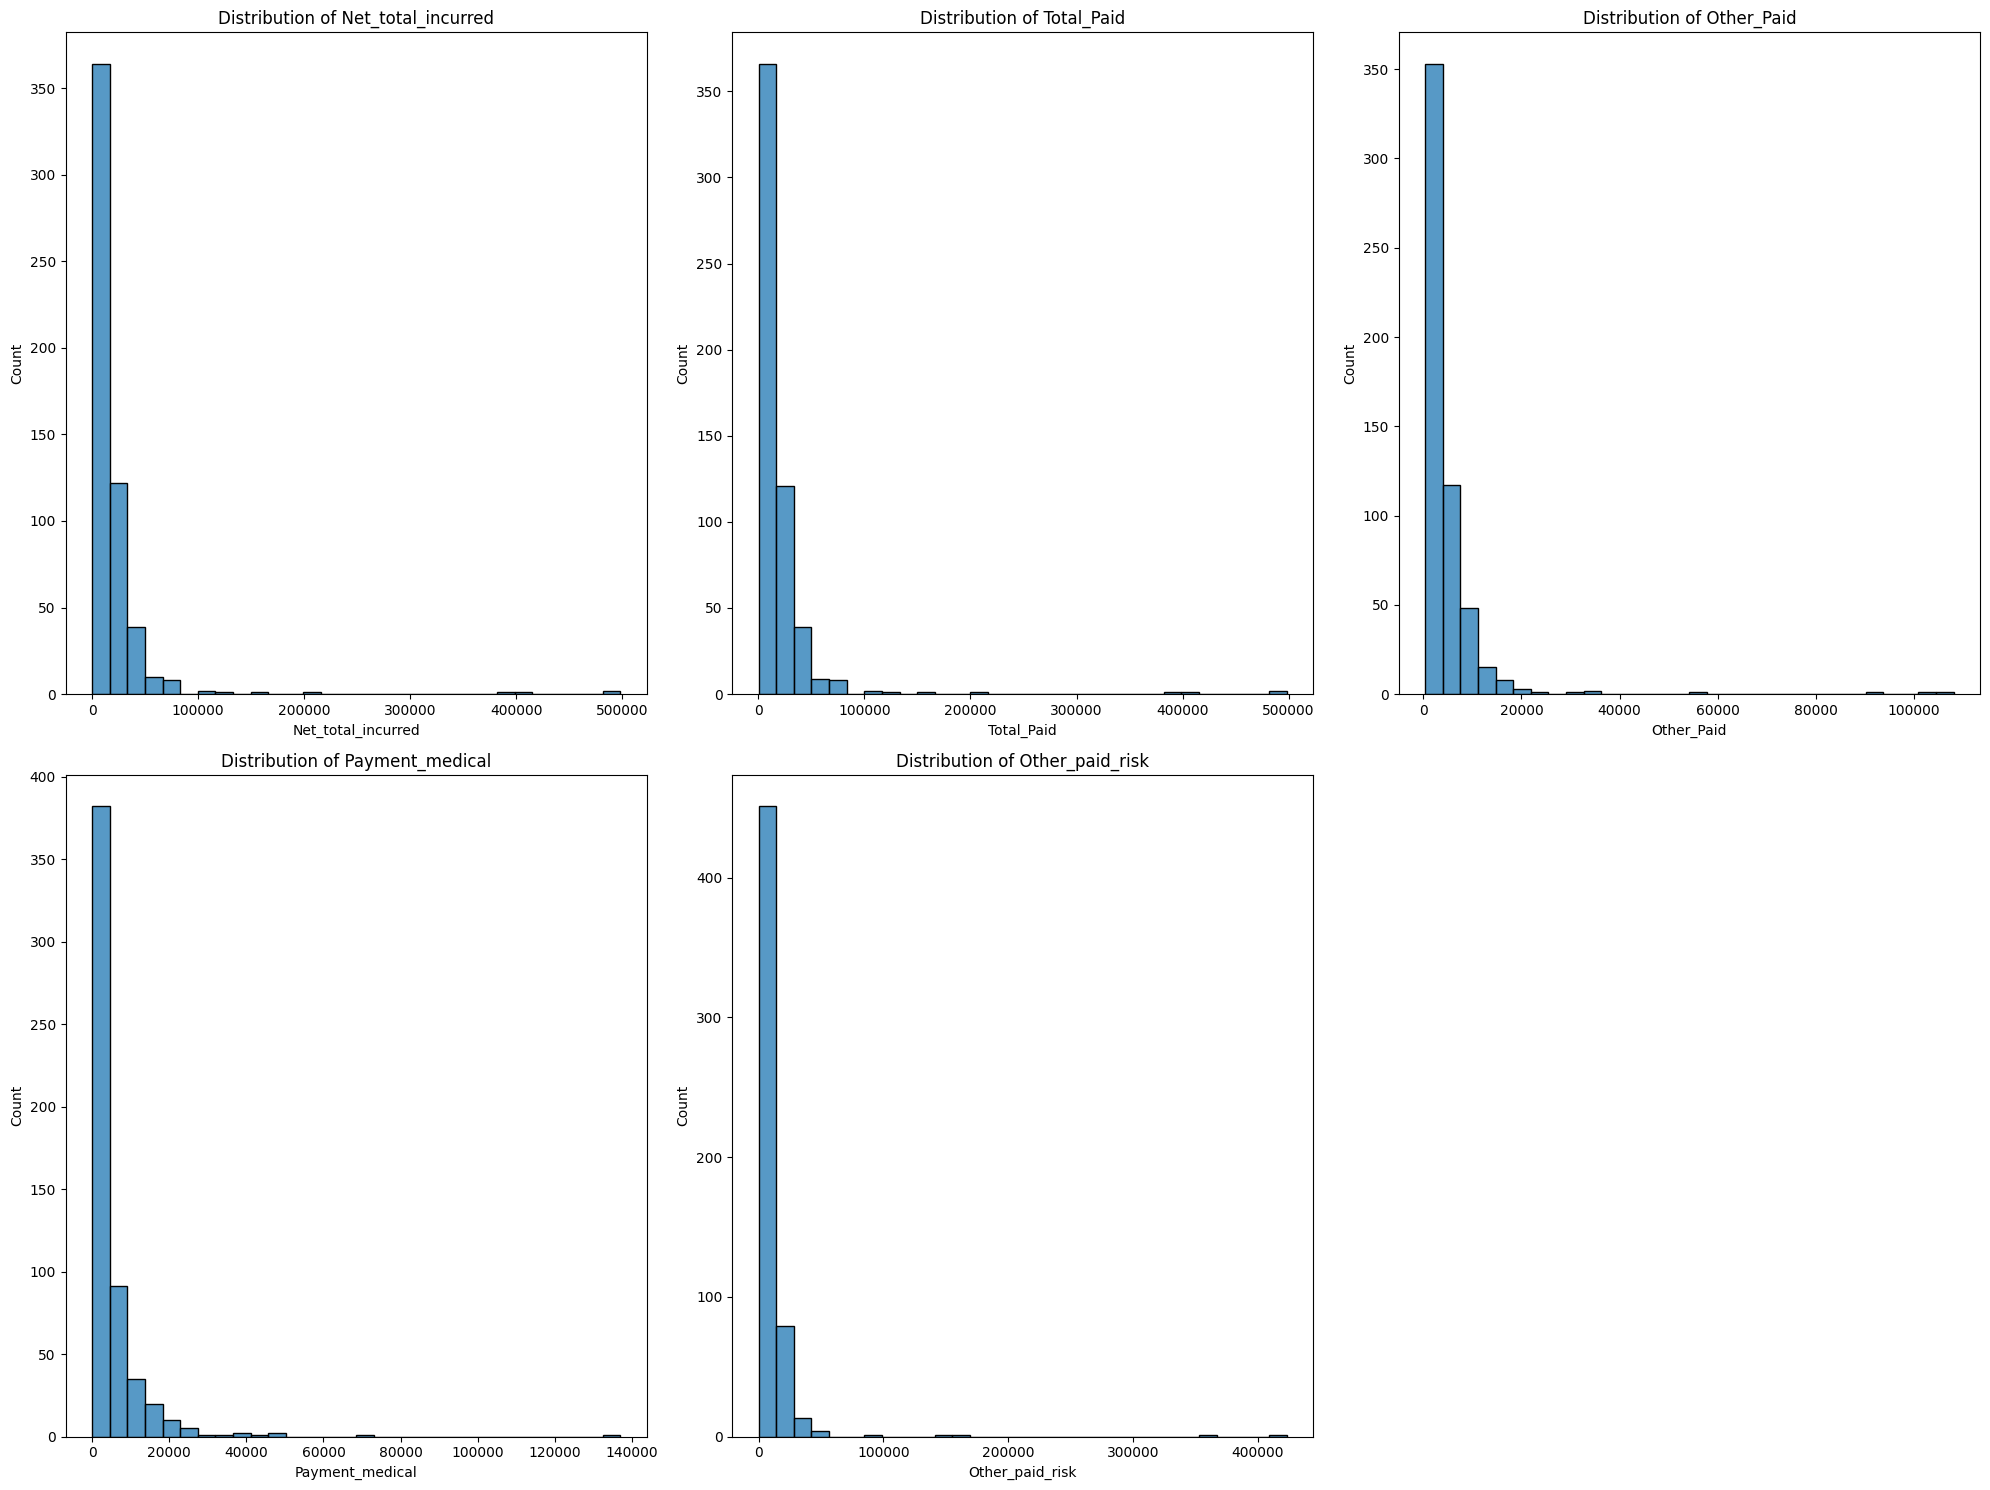

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# List of categorical and numerical target variables
categorical_targets = ['Fitness_week2', 'Fitness_week6', 'Fitness_week12', 'Fitness_week26', 'Fitness_week52']
numerical_targets = ['Net_total_incurred', 'Total_Paid', 'Other_Paid', 'Payment_medical', 'Other_paid_risk']

# Plot histograms for numerical targets
for i, target in enumerate(numerical_targets, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_imputed[target], kde=False, bins=30)
    plt.title(f'Distribution of {target}')

# Show the plot
plt.tight_layout()
plt.show()

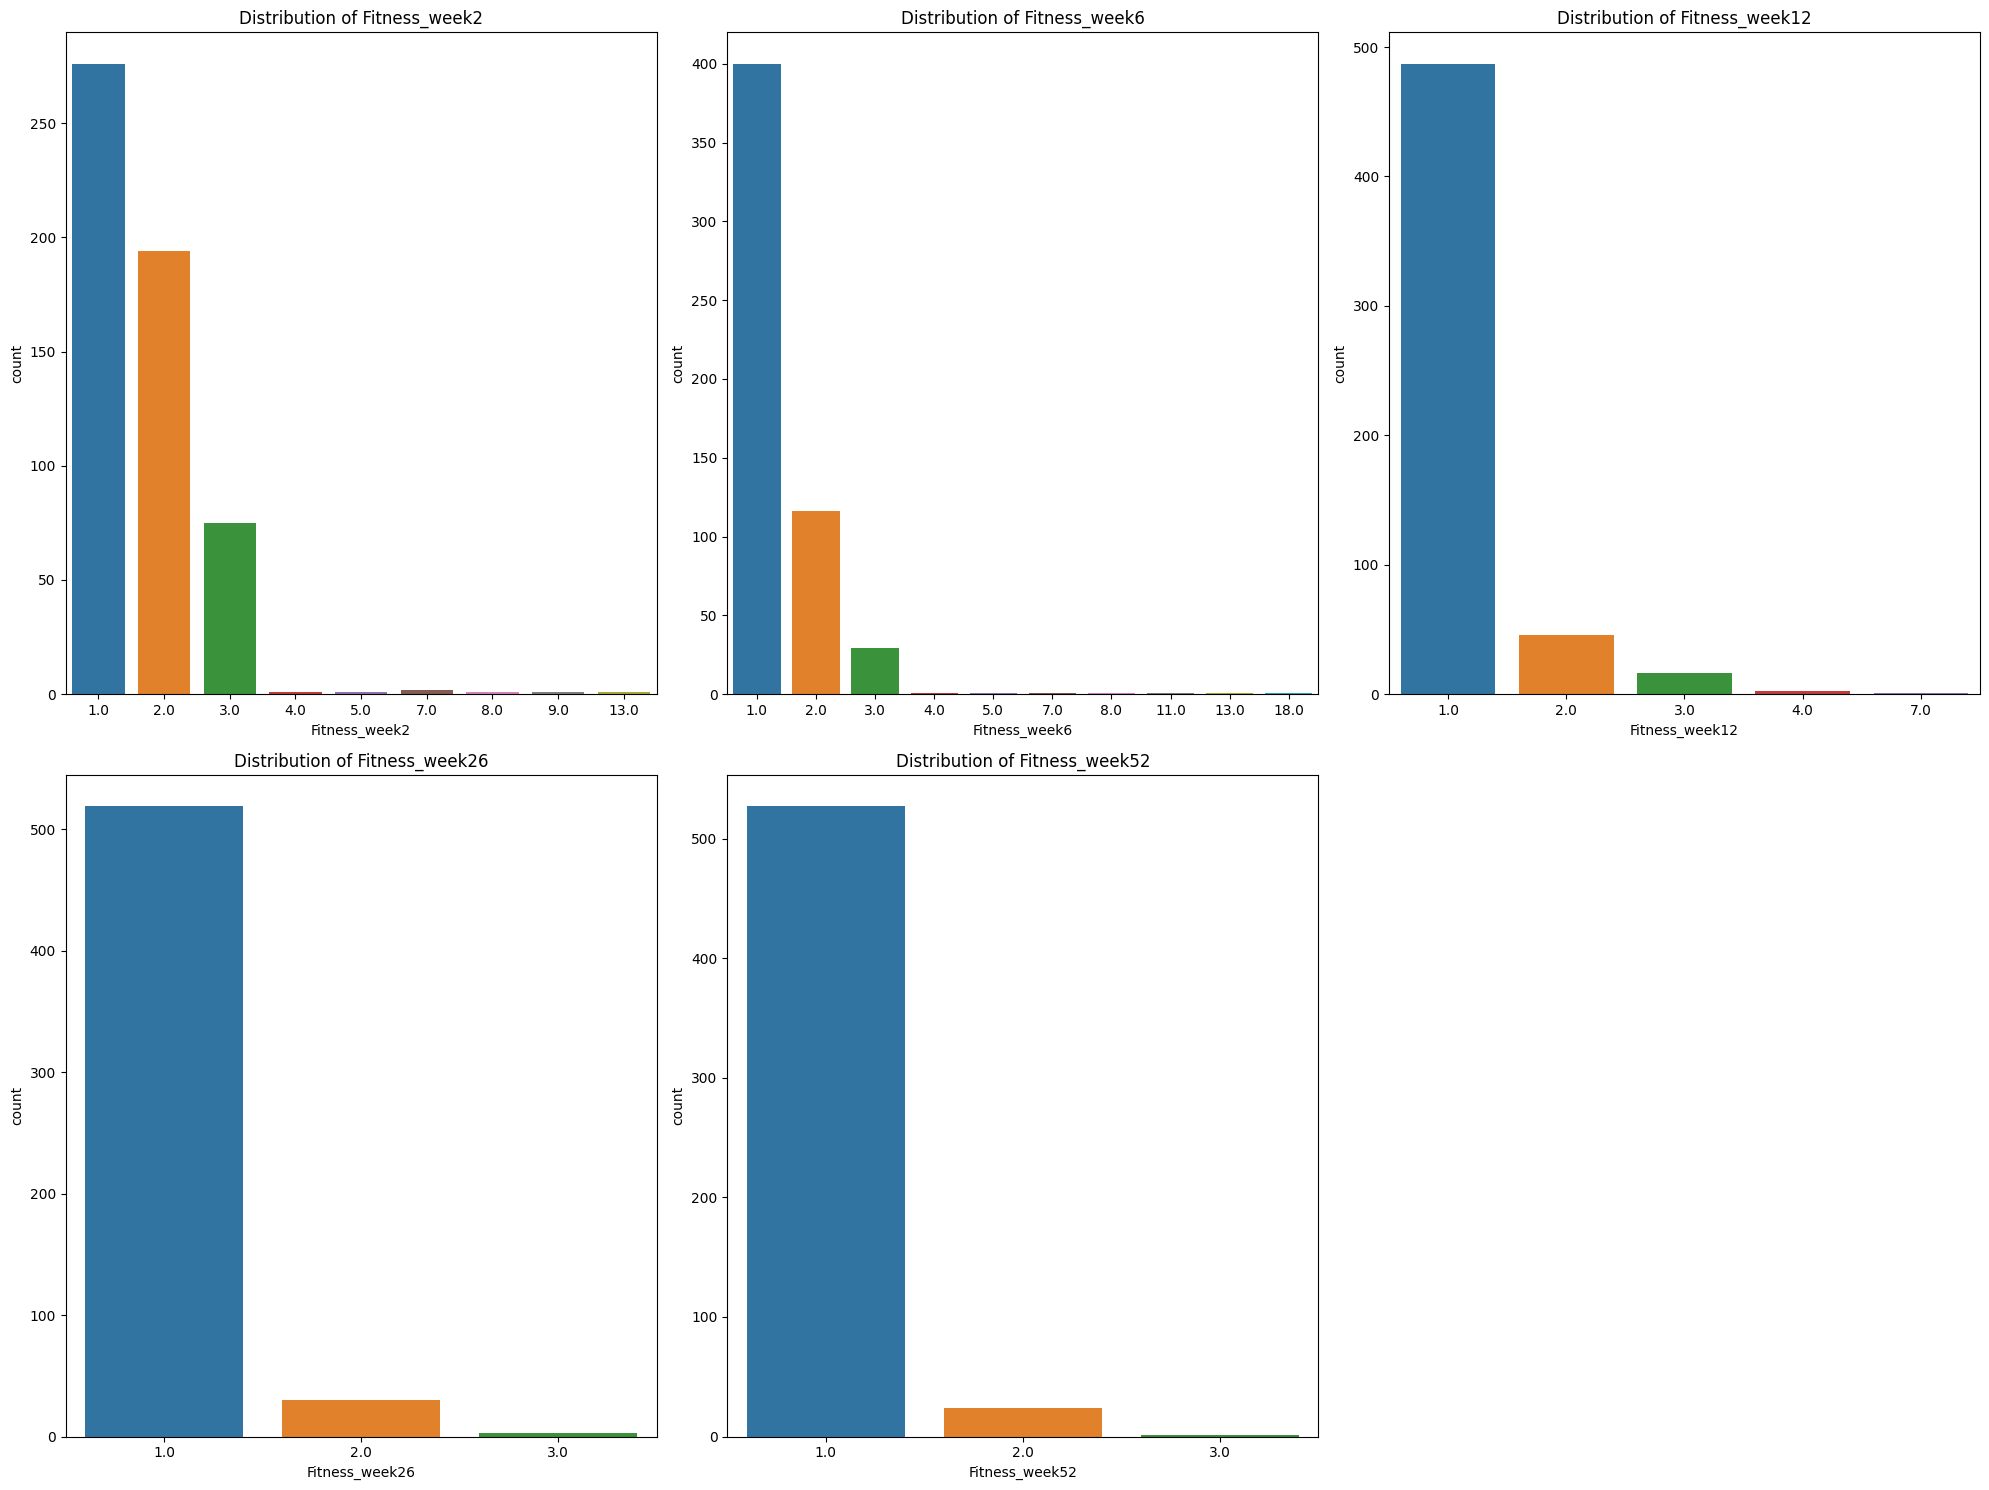

In [150]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Plot bar plots for categorical targets
for i, target in enumerate(categorical_targets, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=target, data=df_imputed)
    plt.title(f'Distribution of {target}')

# Show the plot
plt.tight_layout()
plt.show()

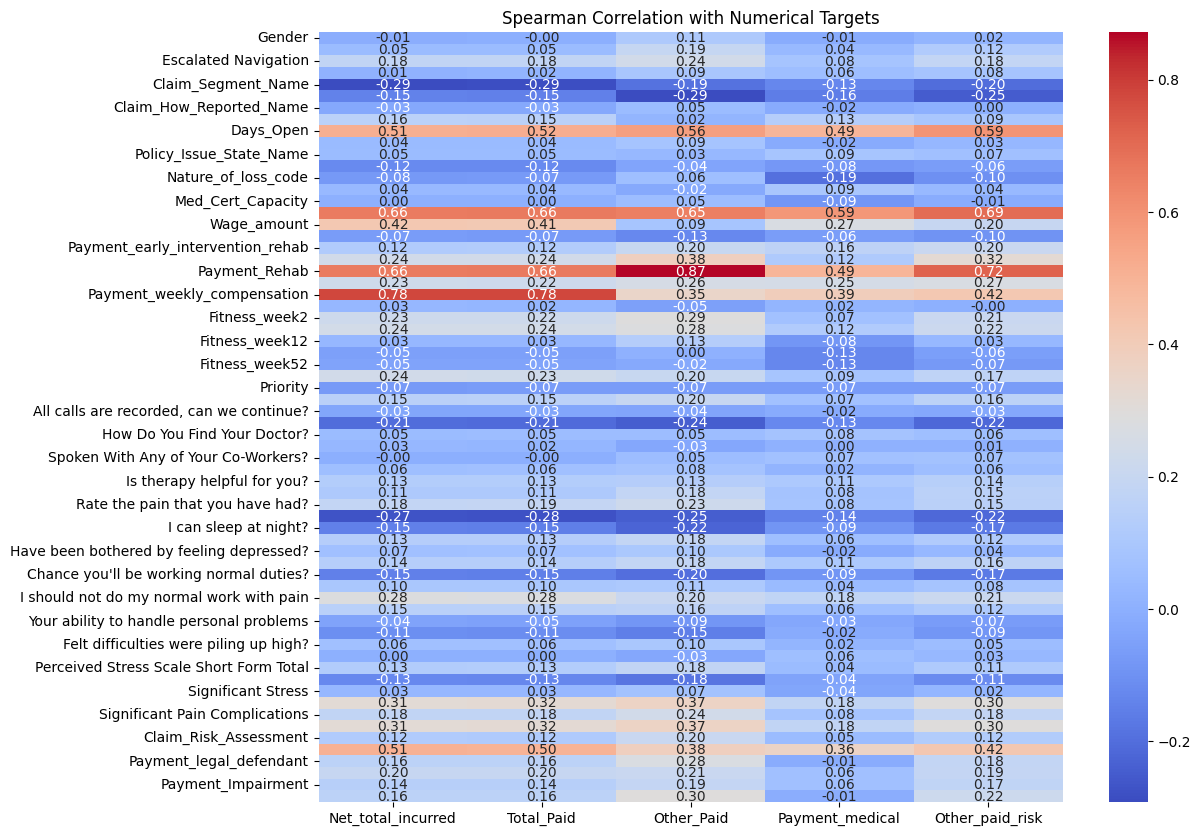

In [151]:
# Calculate the Spearman correlation matrix for numerical targets
spearman_corr_matrix = df_imputed.corr(method='spearman')

# Filter correlations for the numerical targets
spearman_corr_with_numerical_targets = spearman_corr_matrix[numerical_targets].drop(numerical_targets)

# Plot heatmap for correlations
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr_with_numerical_targets, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation with Numerical Targets")
plt.show()

In [152]:
# from scipy.stats import chi2_contingency
# import pandas as pd

# # Initialize an empty DataFrame to store Chi-Squared test results
# chi2_results = pd.DataFrame(columns=['Target', 'Feature', 'p-value'])

# # Loop through each target and feature to perform the Chi-Squared test
# for target in categorical_targets:
#     for feature in categorical_columns:
#         # Skip the comparison if target and feature are the same
#         if target == feature:
#             continue

#         # Create a contingency table
#         contingency_table = pd.crosstab(df_imputed[target], df_imputed[feature])

#         # Perform the Chi-Squared test
#         _, p_value, _, _ = chi2_contingency(contingency_table)

#         # Append the results to the DataFrame
#         chi2_results = chi2_results.append({'Target': target, 'Feature': feature, 'p-value': p_value}, ignore_index=True)

# # Filter features that are dependent on the target (p-value < 0.05)
# chi2_significant_results = chi2_results[chi2_results['p-value'] < 0.05]

# # Display the significant results
# chi2_significant_results.head(10)

In [153]:
# Update the list of categorical columns to reflect the renamed column
categorical_columns = [col if col != 'Fitness_wekk26' else 'Fitness_week26' for col in categorical_columns]

# Initialize an empty DataFrame to store Chi-Squared test results
chi2_results = pd.DataFrame(columns=['Target', 'Feature', 'p-value'])

# Loop through each target and feature to perform the Chi-Squared test
for target in categorical_targets:
    for feature in categorical_columns:
        # Skip the comparison if target and feature are the same
        if target == feature:
            continue

        # Create a contingency table
        contingency_table = pd.crosstab(df_imputed[target], df_imputed[feature])

        # Perform the Chi-Squared test
        _, p_value, _, _ = chi2_contingency(contingency_table)

        # Append the results to the DataFrame
        chi2_results = chi2_results.append({'Target': target, 'Feature': feature, 'p-value': p_value}, ignore_index=True)

# Filter features that are dependent on the target (p-value < 0.05)
chi2_significant_results = chi2_results[chi2_results['p-value'] < 0.05]

# Display the significant results
chi2_significant_results.head(10)

,Target,Feature,p-value
1,Fitness_week2,State,1.103110e-268
2,Fitness_week2,Escalated Navigation,1.519746e-04
3,Fitness_week2,Intervention Required,6.867431e-132
4,Fitness_week2,Claim_Segment_Name,1.977855e-31
5,Fitness_week2,Date_of_Accident,6.201889e-58
7,Fitness_week2,Claim_Finalised_Date,8.517819e-30
8,Fitness_week2,RTW_Plan_Status_Name,9.735598e-03
9,Fitness_week2,Policy_Issue_State_Name,5.633432e-04
11,Fitness_week2,Med_Cert_Capacity,3.960846e-05
12,Fitness_week2,Interstate_workers_flag,1.882343e-04


In [154]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Initialize an empty DataFrame to store RFE results for numerical targets
rfe_results_numerical = pd.DataFrame(columns=['Target', 'Selected Features'])

# Perform RFE for each numerical target
for target in numerical_targets:
    # Initialize the model
    model = LinearRegression()

    # Initialize RFE
    selector = RFE(model, n_features_to_select=10, step=1)

    # Fit RFE
    X = df_imputed.drop(target_variables, axis=1)
    y = df_imputed[target]
    selector = selector.fit(X, y)

    # Get selected features
    selected_features = X.columns[selector.support_]

    # Append the results to the DataFrame
    rfe_results_numerical = rfe_results_numerical.append({'Target': target, 'Selected Features': selected_features}, ignore_index=True)

# Display RFE results for numerical targets
rfe_results_numerical


,Target,Selected Features
0,Net_total_incurred,"Index(['Gender', 'Intervention Required', 'Cla..."
1,Total_Paid,"Index(['Gender', 'Intervention Required', 'Cla..."
2,Other_Paid,"Index(['State', 'Intervention Required', 'Clai..."
3,Payment_medical,"Index(['Work Status at Referral', 'Priority', ..."
4,Other_paid_risk,"Index(['State', 'Intervention Required', 'Clai..."


In [155]:
from sklearn.ensemble import RandomForestClassifier

# Initialize an empty DataFrame to store feature importances for categorical targets
feature_importance_results = pd.DataFrame(columns=['Target', 'Top 10 Important Features'])

# Perform Random Forest feature importance for each categorical target
for target in categorical_targets:
    # Initialize Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)

    # Fit the model
    X = df_imputed.drop(target_variables, axis=1)
    y = df_imputed[target]
    rf_clf.fit(X, y)

    # Get feature importances
    feature_importances = pd.Series(rf_clf.feature_importances_, index=X.columns)

    # Get top 10 important features
    top_10_features = feature_importances.nlargest(10).index.tolist()

    # Append the results to the DataFrame
    feature_importance_results = feature_importance_results.append({'Target': target, 'Top 10 Important Features': top_10_features}, ignore_index=True)

# Display feature importances for categorical targets
feature_importance_results

,Target,Top 10 Important Features
0,Fitness_week2,"[Work Status at Referral, How long have you ha..."
1,Fitness_week6,"[Work Status at Referral, How long have you ha..."
2,Fitness_week12,"[Med_Cert_Capacity, Date_of_Accident, How long..."
3,Fitness_week26,"[Med_Cert_Capacity, Med_cert_unfit_restricted_..."
4,Fitness_week52,"[Med_Cert_Capacity, Med_cert_unfit_restricted_..."


In [156]:
# Calculate the correlation matrix for all features
correlation_matrix = df_imputed.corr().abs()

# Create a DataFrame to store highly correlated pairs
highly_correlated_pairs = pd.DataFrame(columns=['Feature 1', 'Feature 2', 'Correlation'])

# Iterate through the correlation matrix to identify highly correlated pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > 0.7:
            highly_correlated_pairs = highly_correlated_pairs.append(
                {
                    'Feature 1': correlation_matrix.columns[i],
                    'Feature 2': correlation_matrix.columns[j],
                    'Correlation': correlation_matrix.iloc[i, j]
                },
                ignore_index=True
            )

# Display the highly correlated pairs
highly_correlated_pairs.sort_values(by='Correlation', ascending=False)

,Feature 1,Feature 2,Correlation
16,Significant Pain Complications,Escalated Navigation,1.000000
14,Z-Score,Perceived Stress Scale Short Form Total,0.999997
27,Total_Paid,Net_total_incurred,0.999885
19,Orebro Musculoskeletal Pain Total,First Orebro Score,0.998598
30,Other_paid_risk,Payment_legal_plaintiff,0.896337
33,Other_paid_risk,Other_Paid,0.850190
2,Fitness_week6,Fitness_week2,0.819429
32,Other_paid_risk,Total_Paid,0.817432
31,Other_paid_risk,Net_total_incurred,0.817358
0,Date_of_Accident,State,0.813532


In [157]:
# Initialize a DataFrame to store the data with interaction terms
df_with_interactions = df_imputed.copy()

# Create interaction terms for highly correlated pairs
for index, row in highly_correlated_pairs.iterrows():
    new_interaction_col = f"{row['Feature 1']}_x_{row['Feature 2']}"
    df_with_interactions[new_interaction_col] = df_with_interactions[row['Feature 1']] * df_with_interactions[row['Feature 2']]

# Display some of the newly created interaction terms
df_with_interactions[list(df_with_interactions.columns)[-10:]].head()

,Total_Paid_x_Payment_weekly_compensation,Total_Paid_x_Payment_legal_defendant,Total_Paid_x_Payment_legal_plaintiff,Total_Paid_x_Net_total_incurred,Other_Paid_x_Net_total_incurred,Other_Paid_x_Total_Paid,Other_paid_risk_x_Payment_legal_plaintiff,Other_paid_risk_x_Net_total_incurred,Other_paid_risk_x_Total_Paid,Other_paid_risk_x_Other_Paid
0,2.825680e+07,0.0,0.0,1.773089e+08,1.436875e+07,1.436875e+07,0.0,1.490521e+08,1.490521e+08,1.207888e+07
1,0.000000e+00,0.0,0.0,1.121797e+08,5.346489e+07,5.346489e+07,0.0,1.121797e+08,1.121797e+08,5.346489e+07
2,4.099173e+06,0.0,0.0,9.264840e+06,3.515612e+06,3.515612e+06,0.0,5.165667e+06,5.165667e+06,1.960150e+06
3,0.000000e+00,0.0,0.0,6.302772e+07,3.056515e+06,3.056515e+06,0.0,6.302772e+07,6.302772e+07,3.056515e+06
4,3.362607e+08,0.0,0.0,5.483315e+08,1.803069e+07,1.803069e+07,0.0,2.120709e+08,2.120709e+08,6.973490e+06


In [158]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor

# # Separate features and targets from the DataFrame with interaction terms
# X = df_with_interactions.drop(target_variables, axis=1)
# y = df_with_interactions[target_variables]

# # Define columns for different transformations
# numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
# categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# # Preprocessing for numerical data: standardization
# numerical_transformer = StandardScaler()

# # Preprocessing for categorical data: one-hot encoding
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# # Bundle preprocessing for numerical and categorical data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)])

# # Define the models for multi-output tasks
# model_regressor = RandomForestRegressor(n_estimators=100, random_state=0)
# model_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# # Create the pipelines
# pipeline_regressor = Pipeline(steps=[('preprocessor', preprocessor),
#                                      ('model', MultiOutputRegressor(model_regressor))])

# pipeline_classifier = Pipeline(steps=[('preprocessor', preprocessor),
#                                       ('model', MultiOutputClassifier(model_classifier))])

# # Fit the pipelines
# # For regression targets
# pipeline_regressor.fit(X, y[numerical_targets])

# # For classification targets
# pipeline_classifier.fit(X, y[categorical_targets])

# # The pipelines are now fitted and can be used for predictions
# "Pipeline fitting is complete."

In [159]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor

# Separate features and targets from the DataFrame with interaction terms
X = df_with_interactions.drop(target_variables, axis=1)
y = df_with_interactions[target_variables]

# Define columns for different transformations
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical data: standardization
numerical_transformer = StandardScaler()

# Preprocessing for categorical data: one-hot encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the models for multi-output tasks
model_regressor = RandomForestRegressor(n_estimators=100, random_state=0)
model_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# Create the pipelines
pipeline_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('model', MultiOutputRegressor(model_regressor))])

pipeline_classifier = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', MultiOutputClassifier(model_classifier))])

# Fit the pipelines
# For regression targets
pipeline_regressor.fit(X, y[numerical_targets])

# For classification targets
pipeline_classifier.fit(X, y[categorical_targets])

# The pipelines are now fitted and can be used for predictions
"Pipeline fitting is complete."

'Pipeline fitting is complete.'

In [160]:
# Initialize an empty DataFrame to store cross-validation results for numerical targets
from sklearn.model_selection import cross_val_score
cv_results_numerical = pd.DataFrame(columns=['Target', 'R2 Mean', 'R2 Std Dev'])

# Perform 5-fold cross-validation for each numerical target
for target in numerical_targets:
    # Prepare target data
    y_target = y[target]

    # Create a pipeline for individual targets (RandomForestRegressor)
    pipeline_individual_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                                                    ('model', RandomForestRegressor(n_estimators=100, random_state=0))])

    # Perform cross-validation
    scores = cross_val_score(pipeline_individual_regressor, X, y_target, cv=5, scoring='r2')

    # Append the results to the DataFrame
    cv_results_numerical = cv_results_numerical.append({'Target': target, 'R2 Mean': np.mean(scores), 'R2 Std Dev': np.std(scores)}, ignore_index=True)

# Display the cross-validation results for numerical targets
cv_results_numerical

,Target,R2 Mean,R2 Std Dev
0,Net_total_incurred,0.931050,0.066935
1,Total_Paid,0.938259,0.059764
2,Other_Paid,0.831013,0.094445
3,Payment_medical,0.388832,0.270307
4,Other_paid_risk,0.739968,0.160798


In [161]:
# Initialize an empty DataFrame to store cross-validation results for categorical targets
cv_results_categorical = pd.DataFrame(columns=['Target', 'Accuracy Mean', 'Accuracy Std Dev'])

# Perform 5-fold cross-validation for each categorical target
for target in categorical_targets:
    # Prepare target data
    y_target = y[target]

    # Create a pipeline for individual targets (RandomForestClassifier)
    pipeline_individual_classifier = Pipeline(steps=[('preprocessor', preprocessor),
                                                     ('model', RandomForestClassifier(n_estimators=100, random_state=0))])

    # Perform cross-validation
    scores = cross_val_score(pipeline_individual_classifier, X, y_target, cv=5, scoring='accuracy')

    # Append the results to the DataFrame
    cv_results_categorical = cv_results_categorical.append({'Target': target, 'Accuracy Mean': np.mean(scores), 'Accuracy Std Dev': np.std(scores)}, ignore_index=True)

# Display the cross-validation results for categorical targets
cv_results_categorical

,Target,Accuracy Mean,Accuracy Std Dev
0,Fitness_week2,0.896708,0.017028
1,Fitness_week6,0.938460,0.022291
2,Fitness_week12,0.963800,0.009780
3,Fitness_week26,0.987338,0.007224
4,Fitness_week52,0.990975,0.008058
